#Segmenting and Clustering Neighborhoods in Toronto

##Insert software packages into Python

In [42]:
import numpy as np 
import pandas as pd 
from pandas.io.json import json_normalize 
import json 
import requests 
from bs4 import BeautifulSoup 

from sklearn.cluster import KMeans 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium 

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         868 KB

The following NEW packages will be INSTALLED:

    altair:  3.2.0-py36_0 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge


altair-3.2.0         | 770 KB    | #################################

##Import Data

In [62]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})

headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")

rows=table.findAll('tr')
rows=rows[1:len(rows)]

for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")


df=pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n = 2, expand = True) 
df.drop(columns=[0],inplace=True)

df = df.drop(df[(df.Borough == "Not assigned")].index)

df.Neighbourhood.replace("Not assigned", df.Borough, inplace=True)


df.Neighbourhood.fillna(df.Borough, inplace=True)

df=df.drop_duplicates()

df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

df.update(
    df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace(", Toronto",""))
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace("\(Toronto\)",""))

df2 = pd.DataFrame({'Postcode':df.Postcode.unique()})
df2['Borough']=pd.DataFrame(list(set(df['Borough'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=pd.Series(list(set(df['Neighbourhood'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=df2['Neighborhood'].apply(lambda x: ', '.join(x))
df2.dtypes
df2 = df2.rename(columns={'Postcode': 'Postal Code'})
df2.head(12)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park (Toronto),Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,"Scarborough, Toronto","Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [107]:
print('  {} Toronto Postal Codes'.format(df2['Postal Code'].unique().shape[0]))
print('  {} Toronto Boroughs'.format(df2['Borough'].unique().shape[0]))
print('  {} Toronto Neighborhoods'.format(df2['Neighborhood'].unique().shape[0]))

  103 Toronto Postal Codes
  12 Toronto Boroughs
  103 Toronto Neighborhoods


In [64]:
group = df2.groupby('Postal Code')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postal Code', 'Borough', 'Neighborhood']

grouped_df.head(12)

,Postal Code,Borough,Neighborhood
0,M1B,"Scarborough, Toronto","Malvern, Rouge"
1,M1C,"Scarborough, Toronto","Port Union, Highland Creek , Rouge Hill"
2,M1E,"Scarborough, Toronto","Guildwood, West Hill, Morningside"
3,M1G,"Scarborough, Toronto",Woburn
4,M1H,"Scarborough, Toronto",Cedarbrae
5,M1J,"Scarborough, Toronto",Scarborough Village
6,M1K,"Scarborough, Toronto","East Birchmount Park, Kennedy Park, Ionview"
7,M1L,"Scarborough, Toronto","Golden Mile, Oakridge, Clairlea"
8,M1M,"Scarborough, Toronto","Cliffside, Scarborough Village West, Cliffcrest"
9,M1N,"Scarborough, Toronto","Cliffside West, Birch Cliff"


In [111]:
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.set_index("Postal Code")
df2.set_index("Postal Code")
toronto_data=pd.merge(df2, dfll)
toronto_data.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park (Toronto),Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,"Scarborough, Toronto","Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


In [114]:
toronto_data

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park (Toronto),Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,"Scarborough, Toronto","Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


##Find postcode pair and distance

In [115]:
from geopy.distance import great_circle

def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [116]:
coordinates = toronto_data[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.329656,43.753259
7,-79.352188,43.745906


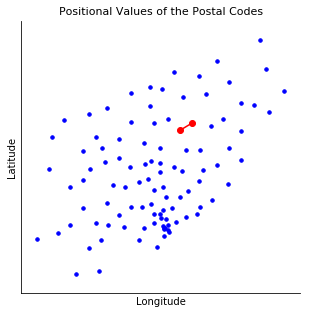

In [117]:
fig = plt.figure(figsize=(5,5))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=12, c='b', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='r', marker="o")

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)
plt.title('Positional Values of the Postal Codes', fontsize=11)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()